In [1]:
#basic
import sys
import os

#parse_arguments
import json
import glob
from collections import namedtuple

#data preprocessing
import numpy as np
from PIL import Image

#siames
#use tf as vsersion 1
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np
import scipy.io
import os.path

#tracker
import matplotlib.pyplot as plt
import time

#visualization
import matplotlib.patches as patches
import matplotlib.pyplot as plt

os.chdir('c:/code/jupyter-notebook/meta-learning/siamese/siamfc-tf')

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
def parse_arguments():
    # load json files
    json_files = glob.glob('parameters/*.json')
    params = []

    for file_name in json_files:
        param_name = os.path.splitext(os.path.basename(file_name))[0]
        with open(file_name) as json_file:
            param = dict(json.load(json_file))
            # make named tuple
            params.append(namedtuple(param_name, param.keys())(**param))
    return params

In [3]:
# image variable
pos_x_ph = tf.placeholder(tf.float64)
pos_y_ph = tf.placeholder(tf.float64)
z_sz_ph = tf.placeholder(tf.float64)
x_sz0_ph = tf.placeholder(tf.float64)
x_sz1_ph = tf.placeholder(tf.float64)
x_sz2_ph = tf.placeholder(tf.float64)

# model variable
_conv_stride = np.array([2,1,1,1,1])
_filtergroup_yn = np.array([0,1,0,1,1], dtype=bool)
_bnorm_yn = np.array([1,1,1,1,0], dtype=bool)
_relu_yn = np.array([1,1,1,1,0], dtype=bool)
_pool_stride = np.array([2,1,0,0,0]) # 0 means no pool
_pool_sz = 3
_bnorm_adjust = True
assert len(_conv_stride) == len(_filtergroup_yn) == len(_bnorm_yn) == len(_relu_yn) == len(_pool_stride), ('These arrays of flags should have same length')
assert all(_conv_stride) >= True, ('The number of conv layers is assumed to define the depth of the network')
_num_layers = len(_conv_stride)

def pad_frame(im, frame_sz, pos_x, pos_y, patch_sz, avg_chan):
    '''return padded image with avg_chan or 0'''
    c = patch_sz / 2
    xleft_pad = tf.maximum(0, -tf.cast(tf.round(pos_x-c), tf.int32))
    ytop_pad = tf.maximum(0, -tf.cast(tf.round(pos_y - c), tf.int32))
    xright_pad = tf.maximum(0, tf.cast(tf.round(pos_x + c), tf.int32) - frame_sz[1])
    ybottom_pad = tf.maximum(0, tf.cast(tf.round(pos_y + c), tf.int32) - frame_sz[0])
    npad = tf.reduce_max([xleft_pad, ytop_pad, xright_pad, ybottom_pad])
    paddings = [[npad, npad], [npad, npad], [0, 0]]
    impaded = im
    if avg_chan is not None:
        impaded = impaded - avg_chan
    impaded = tf.pad(impaded, paddings, mode='CONSTANT')
    if avg_chan is not None:
        impaded = impaded + avg_chan
    return impaded, npad

def extract_crops_z(im, npad, pos_x, pos_y, sz_src, sz_dst):
    '''return [cropped and resized image]'''
    c = sz_src / 2
    # get top-right corner of bbox and consider padding
    tr_x = npad + tf.cast(tf.round(pos_x - c), tf.int32)
    # Compute size from rounded co-ords to ensure rectangle lies inside padding.
    tr_y = npad + tf.cast(tf.round(pos_y - c), tf.int32)
    width = tf.round(pos_x + c) - tf.round(pos_x - c)
    height = tf.round(pos_y + c) - tf.round(pos_y - c)
    crop = tf.image.crop_to_bounding_box(im,
                                         tf.cast(tr_y, tf.int32),
                                         tf.cast(tr_x, tf.int32),
                                         tf.cast(height, tf.int32),
                                         tf.cast(width, tf.int32))
    crop = tf.image.resize_images(crop, [sz_dst, sz_dst], method=tf.image.ResizeMethod.BILINEAR)
    # crops = tf.stack([crop, crop, crop])
    crops = tf.expand_dims(crop, axis=0)
    return crops

def extract_crops_x(im, npad, pos_x, pos_y, sz_src0, sz_src1, sz_src2, sz_dst):
    '''return [cropped and resized image * 3]'''
    # take center of the biggest scaled source patch
    c = sz_src2 / 2
    # get top-right corner of bbox and consider padding
    tr_x = npad + tf.cast(tf.round(pos_x - c), tf.int32)
    tr_y = npad + tf.cast(tf.round(pos_y - c), tf.int32)
    # Compute size from rounded co-ords to ensure rectangle lies inside padding.
    width = tf.round(pos_x + c) - tf.round(pos_x - c)
    height = tf.round(pos_y + c) - tf.round(pos_y - c)
    search_area = tf.image.crop_to_bounding_box(im,
                                                tf.cast(tr_y, tf.int32),
                                                tf.cast(tr_x, tf.int32),
                                                tf.cast(height, tf.int32),
                                                tf.cast(width, tf.int32))
    # TODO: Use computed width and height here?
    offset_s0 = (sz_src2 - sz_src0) / 2
    offset_s1 = (sz_src2 - sz_src1) / 2

    crop_s0 = tf.image.crop_to_bounding_box(search_area,
                                            tf.cast(offset_s0, tf.int32),
                                            tf.cast(offset_s0, tf.int32),
                                            tf.cast(tf.round(sz_src0), tf.int32),
                                            tf.cast(tf.round(sz_src0), tf.int32))
    crop_s0 = tf.image.resize_images(crop_s0, [sz_dst, sz_dst], method=tf.image.ResizeMethod.BILINEAR)
    crop_s1 = tf.image.crop_to_bounding_box(search_area,
                                            tf.cast(offset_s1, tf.int32),
                                            tf.cast(offset_s1, tf.int32),
                                            tf.cast(tf.round(sz_src1), tf.int32),
                                            tf.cast(tf.round(sz_src1), tf.int32))
    crop_s1 = tf.image.resize_images(crop_s1, [sz_dst, sz_dst], method=tf.image.ResizeMethod.BILINEAR)
    crop_s2 = tf.image.resize_images(search_area, [sz_dst, sz_dst], method=tf.image.ResizeMethod.BILINEAR)
    crops = tf.stack([crop_s0, crop_s1, crop_s2])
    return crops

def _find_params(x, params):
    matching = [s for s in params if x in s]
    assert len(matching)==1, ('Ambiguous param name found')
    return matching

def _import_from_matconvnet(net_path):
    '''
    * return [parameter names, parameter values]
    * examples
        - parameter_names_list : ['br_conv1f', 'br_conv1b', 'br_bn1m', 'br_bn1b', ... ]
        - parameter_values_list :
        [array([[[[ 1.34794759e-02, -8.44943046e-04, -2.93634925e-03, ...,
              -1.69822313e-02,  5.01541793e-03, -3.76835205e-02],
             [ 1.43399732e-02, -2.94838240e-03,  5.11044891e-06, ...,
              -3.74883064e-03,  4.10706131e-03, -6.49191579e-03],
             [ 1.19515602e-03, -2.57003843e-03, -3.49176140e-03, ...,
              -5.56284981e-03,  2.48859567e-03,  4.48455587e-02]],
        ]
    '''
    mat = scipy.io.loadmat(net_path)
    net_dot_mat = mat.get('net')
    # organize parameters to import
    params = net_dot_mat['params']
    params = params[0][0]
    params_names = params['name'][0]
    params_names_list = [params_names[p][0] for p in range(params_names.size)]
    params_values = params['value'][0]
    params_values_list = [params_values[p] for p in range(params_values.size)]
    return params_names_list, params_values_list

def set_convolutional(X, W, b, stride, bn_beta, bn_gamma, bn_mm, bn_mv, filtergroup=False, batchnorm=True,
                      activation=True, scope=None, reuse=False):
    # use the input scope or default to "conv"
    with tf.variable_scope(scope or 'conv', reuse=reuse):
        # sanity check
        W = tf.get_variable("W", W.shape, trainable=False, initializer=tf.constant_initializer(W))
        b = tf.get_variable("b", b.shape, trainable=False, initializer=tf.constant_initializer(b))

        if filtergroup:
            X0, X1 = tf.split(X, 2, 3)
            W0, W1 = tf.split(W, 2, 3)
            h0 = tf.nn.conv2d(X0, W0, strides=[1, stride, stride, 1], padding='VALID')
            h1 = tf.nn.conv2d(X1, W1, strides=[1, stride, stride, 1], padding='VALID')
            h = tf.concat([h0, h1], 3) + b
        else:
            h = tf.nn.conv2d(X, W, strides=[1, stride, stride, 1], padding='VALID') + b

        if batchnorm:
            h = tf.layers.batch_normalization(h, beta_initializer=tf.constant_initializer(bn_beta),
                                              gamma_initializer=tf.constant_initializer(bn_gamma),
                                              moving_mean_initializer=tf.constant_initializer(bn_mm),
                                              moving_variance_initializer=tf.constant_initializer(bn_mv),
                                              training=False, trainable=False)

        if activation:
            h = tf.nn.relu(h)

        return h

# import pretrained Siamese network from matconvnet
def _create_siamese(net_path, net_x, net_z):
    # read mat file from net_path and start TF Siamese graph from placeholders X and Z
    params_names_list, params_values_list = _import_from_matconvnet(net_path)

    # loop through the flag arrays and re-construct network, reading parameters of conv and bnorm layers
    for i in range(_num_layers):
        print('> Layer '+str(i+1))
        # conv
        conv_W_name = _find_params('conv'+str(i+1)+'f', params_names_list)[0]
        conv_b_name = _find_params('conv'+str(i+1)+'b', params_names_list)[0]
        print('\t\tCONV: setting '+conv_W_name+' '+conv_b_name)
        print('\t\tCONV: stride '+str(_conv_stride[i])+', filter-group '+str(_filtergroup_yn[i]))
        conv_W = params_values_list[params_names_list.index(conv_W_name)]
        conv_b = params_values_list[params_names_list.index(conv_b_name)]
        # batchnorm
        if _bnorm_yn[i]:
            bn_beta_name = _find_params('bn'+str(i+1)+'b', params_names_list)[0]
            bn_gamma_name = _find_params('bn'+str(i+1)+'m', params_names_list)[0]
            bn_moments_name = _find_params('bn'+str(i+1)+'x', params_names_list)[0]
            print('\t\tBNORM: setting '+bn_beta_name+' '+bn_gamma_name+' '+bn_moments_name)
            bn_beta = params_values_list[params_names_list.index(bn_beta_name)]
            bn_gamma = params_values_list[params_names_list.index(bn_gamma_name)]
            bn_moments = params_values_list[params_names_list.index(bn_moments_name)]
            bn_moving_mean = bn_moments[:,0]
            bn_moving_variance = bn_moments[:,1]**2 # saved as std in matconvnet
        else:
            bn_beta = bn_gamma = bn_moving_mean = bn_moving_variance = []

        # set up conv "block" with bnorm and activation
        net_x = set_convolutional(net_x, conv_W, np.swapaxes(conv_b,0,1), _conv_stride[i], \
                            bn_beta, bn_gamma, bn_moving_mean, bn_moving_variance, \
                            filtergroup=_filtergroup_yn[i], batchnorm=_bnorm_yn[i], activation=_relu_yn[i], \
                            scope='conv'+str(i+1), reuse=False)

        # notice reuse=True for Siamese parameters sharing
        net_z = set_convolutional(net_z, conv_W, np.swapaxes(conv_b,0,1), _conv_stride[i], \
                            bn_beta, bn_gamma, bn_moving_mean, bn_moving_variance, \
                            filtergroup=_filtergroup_yn[i], batchnorm=_bnorm_yn[i], activation=_relu_yn[i], \
                            scope='conv'+str(i+1), reuse=True)

        # add max pool if required
        if _pool_stride[i]>0:
            print('\t\tMAX-POOL: size '+str(_pool_sz)+ ' and stride '+str(_pool_stride[i]))
            net_x = tf.nn.max_pool(net_x, [1,_pool_sz,_pool_sz,1], strides=[1,_pool_stride[i],_pool_stride[i],1], padding='VALID', name='pool'+str(i+1))
            net_z = tf.nn.max_pool(net_z, [1,_pool_sz,_pool_sz,1], strides=[1,_pool_stride[i],_pool_stride[i],1], padding='VALID', name='pool'+str(i+1))

    print()

    return net_z, net_x, params_names_list, params_values_list

def _match_templates(net_z, net_x, params_names_list, params_values_list):
    # finalize network
    # z, x are [B, H, W, C]
    net_z = tf.transpose(net_z, perm=[1,2,0,3])
    net_x = tf.transpose(net_x, perm=[1,2,0,3])
    # z, x are [H, W, B, C]
    Hz, Wz, B, C = tf.unstack(tf.shape(net_z))
    Hx, Wx, Bx, Cx = tf.unstack(tf.shape(net_x))
    # assert B==Bx, ('Z and X should have same Batch size')
    # assert C==Cx, ('Z and X should have same Channels number')
    net_z = tf.reshape(net_z, (Hz, Wz, B*C, 1))
    net_x = tf.reshape(net_x, (1, Hx, Wx, B*C))
    net_final = tf.nn.depthwise_conv2d(net_x, net_z, strides=[1,1,1,1], padding='VALID')
    # final is [1, Hf, Wf, BC]
    net_final = tf.concat(tf.split(net_final, 3, axis=3), axis=0)
    # final is [B, Hf, Wf, C]
    net_final = tf.expand_dims(tf.reduce_sum(net_final, axis=3), axis=3)
    # final is [B, Hf, Wf, 1]
    if _bnorm_adjust:
        bn_beta = params_values_list[params_names_list.index('fin_adjust_bnb')]
        bn_gamma = params_values_list[params_names_list.index('fin_adjust_bnm')]
        bn_moments = params_values_list[params_names_list.index('fin_adjust_bnx')]
        bn_moving_mean = bn_moments[:,0]
        bn_moving_variance = bn_moments[:,1]**2
        net_final = tf.layers.batch_normalization(net_final, beta_initializer=tf.constant_initializer(bn_beta),
                                                gamma_initializer=tf.constant_initializer(bn_gamma),
                                                moving_mean_initializer=tf.constant_initializer(bn_moving_mean),
                                                moving_variance_initializer=tf.constant_initializer(bn_moving_variance),
                                                training=False, trainable=False)

    return net_final

def build_tracking_graph(final_score_sz, design, env):
    filename = tf.placeholder(tf.string, [], name='filename')
    image_file = tf.read_file(filename)
    image = tf.image.decode_image(image_file)
    image = 255.0 * tf.image.convert_image_dtype(image, tf.float32)
    frame_sz = tf.shape(image)
    if design.pad_with_image_mean:
        avg_chan = tf.reduce_mean(image, axis=(0,1), name='avg_chan')
    else:
        avg_chan = None
    # padding image
    frame_padded_z, npad_z = pad_frame(image, frame_sz, pos_x_ph, pos_y_ph, z_sz_ph, avg_chan)
    frame_padded_z = tf.cast(frame_padded_z, tf.float32)
    # extract tensor of z_crops
    z_crops = extract_crops_z(frame_padded_z, npad_z, pos_x_ph, pos_y_ph, z_sz_ph, design.exemplar_sz)
    frame_padded_x, npad_x = pad_frame(image, frame_sz, pos_x_ph, pos_y_ph, x_sz2_ph, avg_chan)
    frame_padded_x = tf.cast(frame_padded_x, tf.float32)
    # extract tensor of x_crops (3 scales)
    x_crops = extract_crops_x(frame_padded_x, npad_x, pos_x_ph, pos_y_ph, x_sz0_ph, x_sz1_ph, x_sz2_ph, design.search_sz)
    template_z, templates_x, p_names_list, p_val_list = _create_siamese(os.path.join(env.root_pretrained,design.net), x_crops, z_crops)
    template_z = tf.squeeze(template_z)
    templates_z = tf.stack([template_z, template_z, template_z])
    # compare templates via cross-correlation
    scores = _match_templates(templates_z, templates_x, p_names_list, p_val_list)
    # upsample the score maps
    scores_up = tf.image.resize_images(scores, [final_score_sz, final_score_sz],
        method=tf.image.ResizeMethod.BICUBIC, align_corners=True)
    return filename, image, templates_z, scores_up

In [4]:
def show_frame(frame, bbox, fig_n):
    fig = plt.figure(fig_n)
    ax = fig.add_subplot(111)
    r = patches.Rectangle((bbox[0],bbox[1]), bbox[2], bbox[3], linewidth=2, edgecolor='r', fill=False)
    ax.imshow(np.uint8(frame))
    ax.add_patch(r)
    plt.ion()
    plt.show()
    plt.pause(0.001)
    plt.clf()

def tracker(hp, run, design, frame_name_list, pos_x, pos_y, target_w, target_h, final_score_sz, filename, image, templates_z, scores, start_frame):
    num_frames = np.size(frame_name_list)
    # stores tracker's output for evaluation
    bboxes = np.zeros((num_frames,4))

    scale_factors = hp.scale_step**np.linspace(-np.ceil(hp.scale_num/2), np.ceil(hp.scale_num/2), hp.scale_num)
    # cosine window to penalize large displacements
    hann_1d = np.expand_dims(np.hanning(final_score_sz), axis=0)
    penalty = np.transpose(hann_1d) * hann_1d
    penalty = penalty / np.sum(penalty)

    context = design.context*(target_w+target_h)
    z_sz = np.sqrt(np.prod((target_w+context)*(target_h+context)))
    x_sz = float(design.search_sz) / design.exemplar_sz * z_sz

    # thresholds to saturate patches shrinking/growing
    min_z = hp.scale_min * z_sz
    max_z = hp.scale_max * z_sz
    min_x = hp.scale_min * x_sz
    max_x = hp.scale_max * x_sz

    # run_metadata = tf.RunMetadata()
    # run_opts = {
    #     'options': tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE),
    #     'run_metadata': run_metadata,
    # }

    run_opts = {}

    # with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:
    with tf.Session() as sess:
        tf.global_variables_initializer().run()
        # Coordinate the loading of image files.
        coord = tf.train.Coordinator()
        threads = tf.train.start_queue_runners(coord=coord)

        # save first frame position (from ground-truth)
        bboxes[0,:] = pos_x-target_w/2, pos_y-target_h/2, target_w, target_h

        image_, templates_z_ = sess.run([image, templates_z], feed_dict={
                                                                        pos_x_ph: pos_x,
                                                                        pos_y_ph: pos_y,
                                                                        z_sz_ph: z_sz,
                                                                        filename: frame_name_list[0]})
        new_templates_z_ = templates_z_

        t_start = time.time()

        # Get an image from the queue
        for i in range(1, num_frames):
            scaled_exemplar = z_sz * scale_factors
            scaled_search_area = x_sz * scale_factors
            scaled_target_w = target_w * scale_factors
            scaled_target_h = target_h * scale_factors
            image_, scores_ = sess.run(
                [image, scores],
                feed_dict={
                    pos_x_ph: pos_x,
                    pos_y_ph: pos_y,
                    x_sz0_ph: scaled_search_area[0],
                    x_sz1_ph: scaled_search_area[1],
                    x_sz2_ph: scaled_search_area[2],
                    templates_z: np.squeeze(templates_z_),
                    filename: frame_name_list[i],
                }, **run_opts)
            scores_ = np.squeeze(scores_)
            # penalize change of scale
            scores_[0,:,:] = hp.scale_penalty*scores_[0,:,:]
            scores_[2,:,:] = hp.scale_penalty*scores_[2,:,:]
            # find scale with highest peak (after penalty)
            new_scale_id = np.argmax(np.amax(scores_, axis=(1,2)))
            # update scaled sizes
            x_sz = (1-hp.scale_lr)*x_sz + hp.scale_lr*scaled_search_area[new_scale_id]
            target_w = (1-hp.scale_lr)*target_w + hp.scale_lr*scaled_target_w[new_scale_id]
            target_h = (1-hp.scale_lr)*target_h + hp.scale_lr*scaled_target_h[new_scale_id]
            # select response with new_scale_id
            score_ = scores_[new_scale_id,:,:]
            score_ = score_ - np.min(score_)
            score_ = score_/np.sum(score_)
            # apply displacement penalty
            score_ = (1-hp.window_influence)*score_ + hp.window_influence*penalty
            pos_x, pos_y = _update_target_position(pos_x, pos_y, score_, final_score_sz, design.tot_stride, design.search_sz, hp.response_up, x_sz)
            # convert <cx,cy,w,h> to <x,y,w,h> and save output
            bboxes[i,:] = pos_x-target_w/2, pos_y-target_h/2, target_w, target_h
            # update the target representation with a rolling average
            if hp.z_lr>0:
                new_templates_z_ = sess.run([templates_z], feed_dict={
                                                                pos_x_ph: pos_x,
                                                                pos_y_ph: pos_y,
                                                                z_sz_ph: z_sz,
                                                                image: image_
                                                                })

                templates_z_=(1-hp.z_lr)*np.asarray(templates_z_) + hp.z_lr*np.asarray(new_templates_z_)

            # update template patch size
            z_sz = (1-hp.scale_lr)*z_sz + hp.scale_lr*scaled_exemplar[new_scale_id]

            if run.visualization and i % 20 == 0:
                show_frame(image_, bboxes[i,:], 1)

        t_elapsed = time.time() - t_start
        speed = num_frames/t_elapsed

        # Finish off the filename queue coordinator.
        coord.request_stop()
        coord.join(threads)

        # from tensorflow.python.client import timeline
        # trace = timeline.Timeline(step_stats=run_metadata.step_stats)
        # trace_file = open('timeline-search.ctf.json', 'w')
        # trace_file.write(trace.generate_chrome_trace_format())

    plt.close('all')

    return bboxes, speed


def _update_target_position(pos_x, pos_y, score, final_score_sz, tot_stride, search_sz, response_up, x_sz):
    # find location of score maximizer
    p = np.asarray(np.unravel_index(np.argmax(score), np.shape(score)))
    # displacement from the center in search area final representation ...
    center = float(final_score_sz - 1) / 2
    disp_in_area = p - center
    # displacement from the center in instance crop
    disp_in_xcrop = disp_in_area * float(tot_stride) / response_up
    # displacement from the center in instance crop (in frame coordinates)
    disp_in_frame = disp_in_xcrop *  x_sz / search_sz
    # *position* within frame in frame coordinates
    pos_y, pos_x = pos_y + disp_in_frame[0], pos_x + disp_in_frame[1]
    return pos_x, pos_y

> Layer 1
		CONV: setting br_conv1f br_conv1b
		CONV: stride 2, filter-group False
		BNORM: setting br_bn1b br_bn1m br_bn1x
Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
Instructions for updating:
Please use `layer.__call__` method instead.
		MAX-POOL: size 3 and stride 2
> Layer 2
		CONV: setting br_conv2f br_conv2b
		CONV: stride 1, filter-group True
		BNORM: setting br_bn2b br_bn2m br_bn2x
		MAX-POOL: size 3 and stride 1
> Layer 3
		CONV: setting br_conv3f br_conv3b
		CONV: stride 1, filter-group False
		BNORM: setting br_bn3b br_bn3m br_bn3x
> Layer 4
		CONV: setting br_conv4f br_conv4b
		CONV: stride 1, filter-group True
		BNORM: setting br_bn4b br_bn4m br_bn4x
> Layer 5
		CONV: setting br_conv5f br_conv5b
		CONV: stride 1, filter-group True

Instructions for updating:
To construct input pipelines, use the

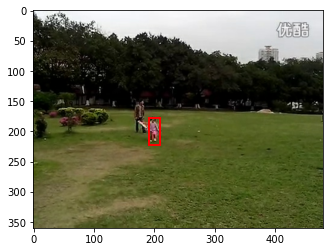

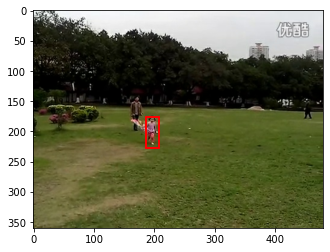

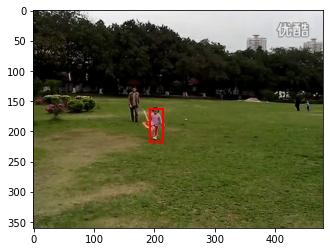

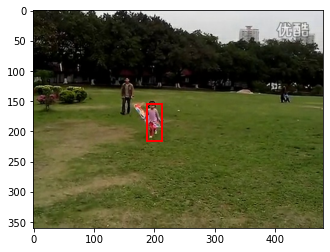

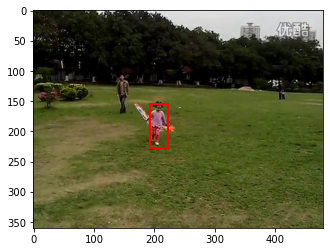

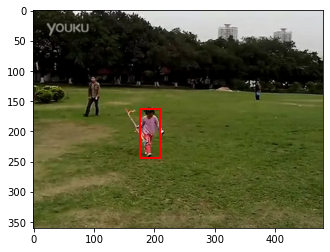

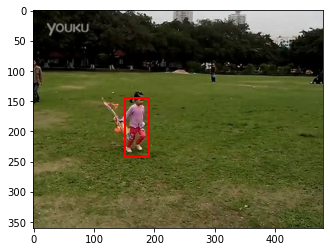

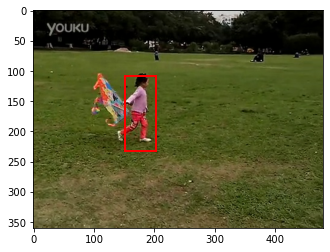

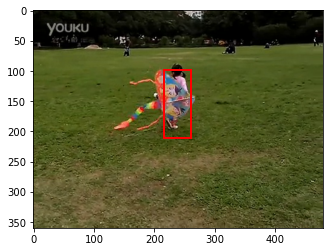

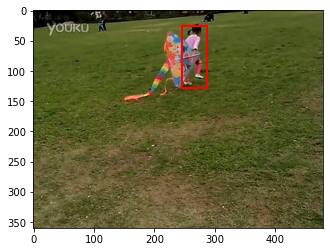

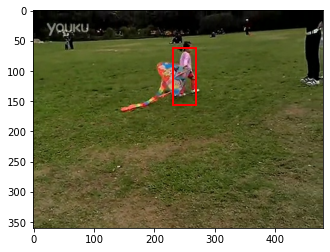

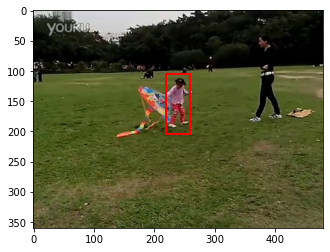

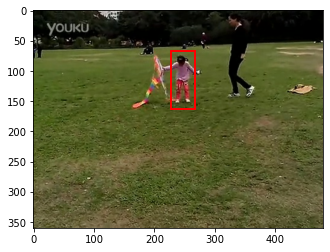

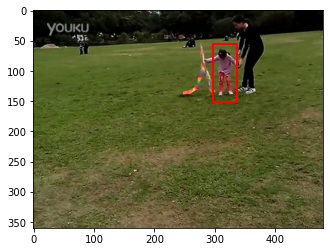

In [5]:
def _init_video(env, evaluation, video):
    video_folder = os.path.join(env.root_dataset, evaluation.dataset, video)
    frame_name_list = [f for f in os.listdir(video_folder) if f.endswith(".jpg")]
    frame_name_list = [os.path.join(env.root_dataset, evaluation.dataset, video, '') + s for s in frame_name_list]
    frame_name_list.sort()
    with Image.open(frame_name_list[0]) as img:
        frame_sz = np.asarray(img.size)
        frame_sz[1], frame_sz[0] = frame_sz[0], frame_sz[1]

    # read the initialization from ground truth
    gt_file = os.path.join(video_folder, 'groundtruth.txt')
    gt = np.genfromtxt(gt_file, delimiter=',')
    n_frames = len(frame_name_list)
    assert n_frames == len(gt), 'Number of frames and number of GT lines should be equal.'

    return gt, frame_name_list, frame_sz, n_frames

def region_to_bbox(region, center=True):

    n = len(region)
    assert n==4 or n==8, ('GT region format is invalid, should have 4 or 8 entries.')

    if n==4:
        x = region[0]
        y = region[1]
        w = region[2]
        h = region[3]
        cx = x+w/2
        cy = y+h/2
        return cx, cy, w, h

def _compute_distance(boxA, boxB):
    a = np.array((boxA[0]+boxA[2]/2, boxA[1]+boxA[3]/2))
    b = np.array((boxB[0]+boxB[2]/2, boxB[1]+boxB[3]/2))
    dist = np.linalg.norm(a - b)

    assert dist >= 0
    assert dist != float('Inf')

    return dist

def _compute_iou(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[0] + boxA[2], boxB[0] + boxB[2])
    yB = min(boxA[1] + boxA[3], boxB[1] + boxB[3])

    if xA < xB and yA < yB:
        # compute the area of intersection rectangle
        interArea = (xB - xA) * (yB - yA)
        # compute the area of both the prediction and ground-truth
        # rectangles
        boxAArea = boxA[2] * boxA[3]
        boxBArea = boxB[2] * boxB[3]
        # compute the intersection over union by taking the intersection
        # area and dividing it by the sum of prediction + ground-truth
        # areas - the intersection area
        iou = interArea / float(boxAArea + boxBArea - interArea)
    else:
        iou = 0

    assert iou >= 0
    assert iou <= 1.01

    return iou

def _compile_results(gt, bboxes, dist_threshold):
    l = np.size(bboxes, 0)
    gt4 = np.zeros((l, 4))
    new_distances = np.zeros(l)
    new_ious = np.zeros(l)
    n_thresholds = 50
    precisions_ths = np.zeros(n_thresholds)

    for i in range(l):
        gt4[i, :] = region_to_bbox(gt[i, :], center=False)
        new_distances[i] = _compute_distance(bboxes[i, :], gt4[i, :])
        new_ious[i] = _compute_iou(bboxes[i, :], gt4[i, :])

    # what's the percentage of frame in which center displacement is inferior to given threshold? (OTB metric)
    precision = sum(new_distances < dist_threshold)/np.size(new_distances) * 100

    # find above result for many thresholds, then report the AUC
    thresholds = np.linspace(0, 25, n_thresholds+1)
    thresholds = thresholds[-n_thresholds:]
    # reverse it so that higher values of precision goes at the beginning
    thresholds = thresholds[::-1]
    for i in range(n_thresholds):
        precisions_ths[i] = sum(new_distances < thresholds[i])/np.size(new_distances)

    # integrate over the thresholds
    precision_auc = np.trapz(precisions_ths)

    # per frame averaged intersection over union (OTB metric)
    iou = np.mean(new_ious) * 100

    return l, precision, precision_auc, iou

def main():
    # load params
    design, env, evaluation, hp, _, _, run  = parse_arguments()
    # idk
    final_score_sz = hp.response_up * (design.score_sz - 1) + 1
    filename, image, templates_z, scores = build_tracking_graph(final_score_sz, design, env)
    gt, frame_name_list, _, _ = _init_video(env, evaluation, evaluation.video)
    pos_x, pos_y, target_w, target_h = region_to_bbox(gt[evaluation.start_frame])
    bboxes, speed = tracker(hp, run, design, frame_name_list, pos_x, pos_y, target_w, target_h, final_score_sz,
                                filename, image, templates_z, scores, evaluation.start_frame)
    _, precision, precision_auc, iou = _compile_results(gt, bboxes, evaluation.dist_threshold)
    print(evaluation.video + \
          ' -- Precision ' + "(%d px)" % evaluation.dist_threshold + ': ' + "%.2f" % precision +\
          ' -- Precision AUC: ' + "%.2f" % precision_auc + \
          ' -- IOU: ' + "%.2f" % iou + \
          ' -- Speed: ' + "%.2f" % speed + ' --')
    print()

main()